In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

In [2]:
#Read in the DLC output
h5_file_path = "/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shuffle1_400000.h5"  
# h5_file_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119623_shuffle1_100000.h5'
#this is from mouse-id 1119976
dataframe = pd.read_hdf(h5_file_path)

#Read in the shelter ROIs
shelter_centroids_coords_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shelter_centroids.npy'
# shelter_coords_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119623_shelter_coords.npy'
shelter_centroids = np.load(shelter_centroids_coords_path)

In [55]:
#this works with the RAW h5 file rather than the Kalman filtered output (bc Kalman filter seems to be crazy right now)

class MouseBehaviorAnalyzer:
    def __init__(self, dataframe, shelters):
        """
        Initialize the class with the dataframe and shelter information.
        :param dataframe: A pandas DataFrame containing DLC tracking data.
        :param shelters: A dictionary with shelter names as keys and their centroids (x, y) as values.
        """
        self.dataframe = dataframe
        self.shelters = shelters


    def compute_head_direction(self) -> np.ndarray:
        """
        This function computes the head direction of the mouse based on DLC tracking data.
        It calculates the angle between the line connecting the ears and a reference axis.

        Returns:
            headDirection: A numpy array of head direction angles in radians, normalized to the range (-π, π].
        """
        # Assuming 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000' is the scorer name
        scorer = 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'

        # Extracting coordinates for left and right ears
        left_ear = self.dataframe[scorer, 'leftear']
        right_ear = self.dataframe[scorer, 'rightear']

        # Calculating deltas
        hedDelta_x = left_ear['x'] - right_ear['x']
        hedDelta_y = left_ear['y'] - right_ear['y']

        # Computing the head direction angle
        headDirection = -np.arctan2(hedDelta_y, hedDelta_x) - np.pi / 2

        # Normalizing angles to range (-π, π]
        headDirection = (headDirection + np.pi) % (2 * np.pi) - np.pi

        return headDirection
    
#if you want to get head angle per second...

    def compute_head_direction_per_second(self, fps=40) -> np.ndarray:
        """
        This function computes the average head direction of the mouse per second based on DLC tracking data.
        It calculates the angle between the line connecting the ears and a reference axis.

        :param fps: Frame per second of the video.
        Returns:
            avg_head_direction_per_second: A numpy array of average head direction angles in radians per second.
        """
        scorer = 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'

        # Extracting coordinates for left and right ears
        left_ear = self.dataframe[scorer, 'leftear']
        right_ear = self.dataframe[scorer, 'rightear']

        # Calculating deltas
        hedDelta_x = left_ear['x'] - right_ear['x']
        hedDelta_y = left_ear['y'] - right_ear['y']

        # Computing the head direction angle for each frame
        headDirection = -np.arctan2(hedDelta_y, hedDelta_x) - np.pi / 2

        # Convert angles to unit vectors
        unit_vectors = np.column_stack((np.cos(headDirection), np.sin(headDirection)))

        # Average the unit vectors per second
        avg_vectors_per_second = np.array([np.mean(unit_vectors[i:i+fps], axis=0) for i in range(0, len(unit_vectors), fps)])

        # Convert averaged unit vectors back to angles
        avg_head_direction_per_second = np.arctan2(avg_vectors_per_second[:, 1], avg_vectors_per_second[:, 0])

        # Normalizing angles to range (-π, π]
        avg_head_direction_per_second = (avg_head_direction_per_second + np.pi) % (2 * np.pi) - np.pi

        return avg_head_direction_per_second

#-----for shelters----
    def angle_to_shelter(self, position, shelter_position):
        """
        Calculate the angle from the mouse position to a shelter.
        """
        delta_x = shelter_position[0] - position[0]
        delta_y = shelter_position[1] - position[1]
        return np.arctan2(delta_y, delta_x)

    def compare_head_direction_to_shelters_per_second(self, fps=40) -> pd.DataFrame:
        """
        For each second, determine the head angle of the mouse toward each shelter.
        Returns a DataFrame with columns for each shelter's head angle per second.
        """
        scorer = 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'
        body_center = self.dataframe[scorer, 'bodycenter']  # Assuming body center represents the position

        head_directions_per_second = self.compute_head_direction_per_second(fps=fps)

        head_angles_to_shelters_per_second = {shelter: [] for shelter in self.shelters}

        for i in range(len(head_directions_per_second)):
            position = (body_center['x'][i * fps], body_center['y'][i * fps])  # Use the position at the start of each second
            head_angle = head_directions_per_second[i]

            for shelter, coords in self.shelters.items():
                shelter_angle = self.angle_to_shelter(position, coords)

                # Calculate the angle difference and store it in the corresponding shelter's list
                angle_diff = np.abs((shelter_angle - head_angle + np.pi) % (2 * np.pi) - np.pi)  # Normalize the difference
                head_angles_to_shelters_per_second[shelter].append(angle_diff)

        # Create a DataFrame from the dictionary of shelter head angles per second
        shelter_head_angles_per_second_df = pd.DataFrame(head_angles_to_shelters_per_second)

        return shelter_head_angles_per_second_df



In [12]:
# Initialize the MouseBehaviorAnalyzer with the tracking data
analyzer = MouseBehaviorAnalyzer(dataframe)

# Compute the head direction
head_directions = analyzer.compute_head_direction_per_second()

# Print the computed head directions
print("Computed Head Directions:", head_directions)

Computed Head Directions: [-2.74730101 -2.74934461 -2.50000562 ... -1.88280523 -1.80814505
 -1.44896055]


/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_64816/11419611.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  left_ear = self.dataframe[scorer, 'leftear']
/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_64816/11419611.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
  right_ear = self.dataframe[scorer, 'rightear']


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Sample head direction data
head_directions = head_directions

# Create an output widget to hold the plot
plot_output = widgets.Output()

def update_plot(frame):
    with plot_output:
        plot_output.clear_output(wait=True)  # Clear the output area
        dx = np.cos(head_directions[frame])
        dy = np.sin(head_directions[frame])
        plt.figure(figsize=(5, 5))
        plt.arrow(0, 0, dx, dy, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.title(f'Head Direction at Second {frame}')
        plt.show()

# Create a slider widget
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(head_directions) - 1,
    step=1,
    description='Second:',
    continuous_update=False
)

# Function to handle slider value changes
def on_slider_change(change):
    update_plot(change['new'])

frame_slider.observe(on_slider_change, names='value')

# Display the slider and output widget
display(frame_slider, plot_output)

# Initialize the plot
update_plot(frame_slider.value)


IntSlider(value=0, continuous_update=False, description='Second:', max=14968)

Output()

## Analyzing mouse's head direction towards each shelter at every second

In [59]:
# Replace this with your actual numpy array
shelter_centroids_array = shelter_centroids

# Convert the numpy array to a dictionary
shelter_centroids_dict = {f'Shelter{i}': tuple(centroid) for i, centroid in enumerate(shelter_centroids_array, start=1)}

# Now you can initialize the MouseBehaviorAnalyzer with this dictionary
analyzer = MouseBehaviorAnalyzer(dataframe, shelter_centroids_dict)


In [60]:
# Step 1: Compute Head Directions (if needed)
# This step might be optional as the comparison method might call it internally
head_directions = analyzer.compute_head_direction_per_second()

# Step 2: Compare Head Direction to Shelters
shelter_facing = analyzer.compare_head_direction_to_shelters_per_second()

# 'shelter_facing' is now an array where each element indicates the shelter the mouse is facing towards
# at each time point.

# You can print or examine the 'shelter_facing' array to understand the mouse's behavior
# print(shelter_facing)

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_64816/3977111957.py:55: PerformanceWarning: indexing past lexsort depth may impact performance.
  left_ear = self.dataframe[scorer, 'leftear']
/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_64816/3977111957.py:56: PerformanceWarning: indexing past lexsort depth may impact performance.
  right_ear = self.dataframe[scorer, 'rightear']
/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_64816/3977111957.py:94: PerformanceWarning: indexing past lexsort depth may impact performance.
  body_center = self.dataframe[scorer, 'bodycenter']  # Assuming body center represents the position


In [85]:
shelter_facing

,Shelter1,Shelter2,Shelter3
0,3.056901,0.662631,1.088496
1,3.099779,0.631837,1.103419
2,2.935643,0.881432,0.852809
3,3.102532,0.734540,1.016290
4,3.004851,0.573361,1.190993
...,...,...,...
14964,2.816665,2.519373,1.772895
14965,2.749585,2.573215,1.677808
14966,2.520199,2.827779,1.478130
14967,2.446805,2.895973,1.398198


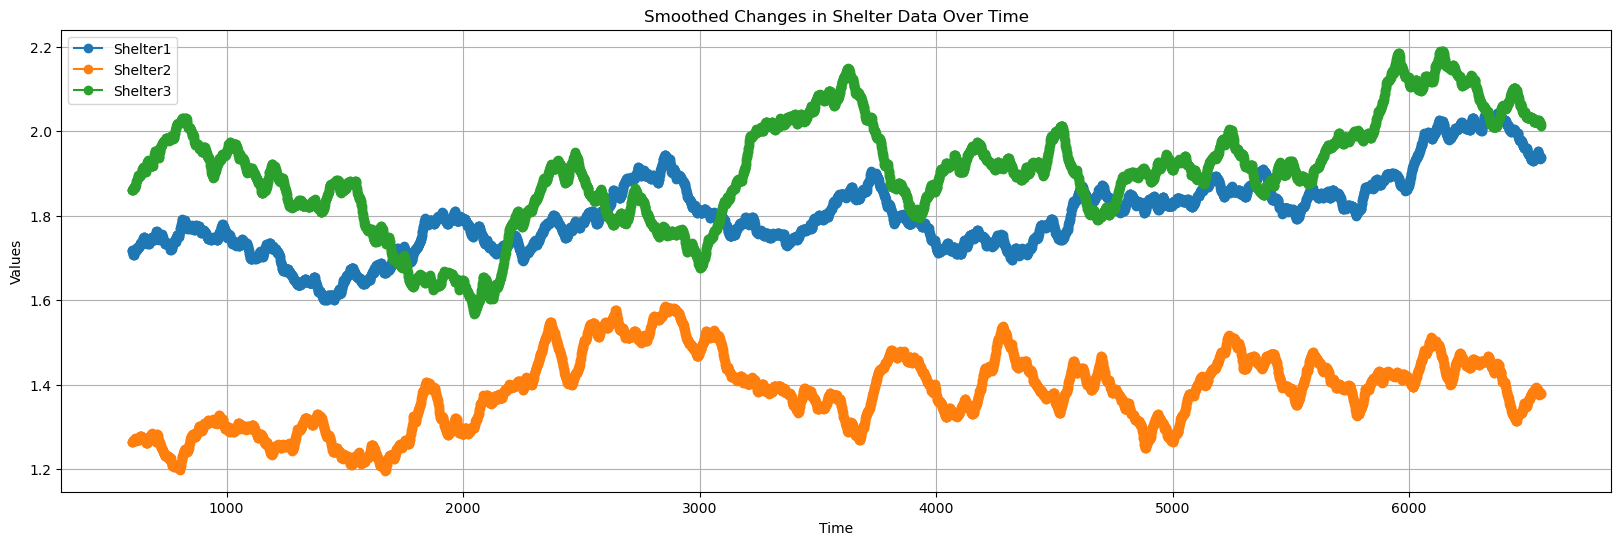

In [91]:
df = shelter_facing[:6559]

# Apply a simple moving average with a window size of 3 (adjust as needed)
smoothed_df = df.rolling(window=600).mean()

# Create a line plot for the smoothed data
plt.figure(figsize=(20, 6))
plt.plot(smoothed_df.index, smoothed_df["Shelter1"], label="Shelter1", marker='o')
plt.plot(smoothed_df.index, smoothed_df["Shelter2"], label="Shelter2", marker='o')
plt.plot(smoothed_df.index, smoothed_df["Shelter3"], label="Shelter3", marker='o')

# Customize the plot
plt.title("Smoothed Changes in Shelter Data Over Time")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
# plt.xlim((0,100))

# Show the plot
plt.show()


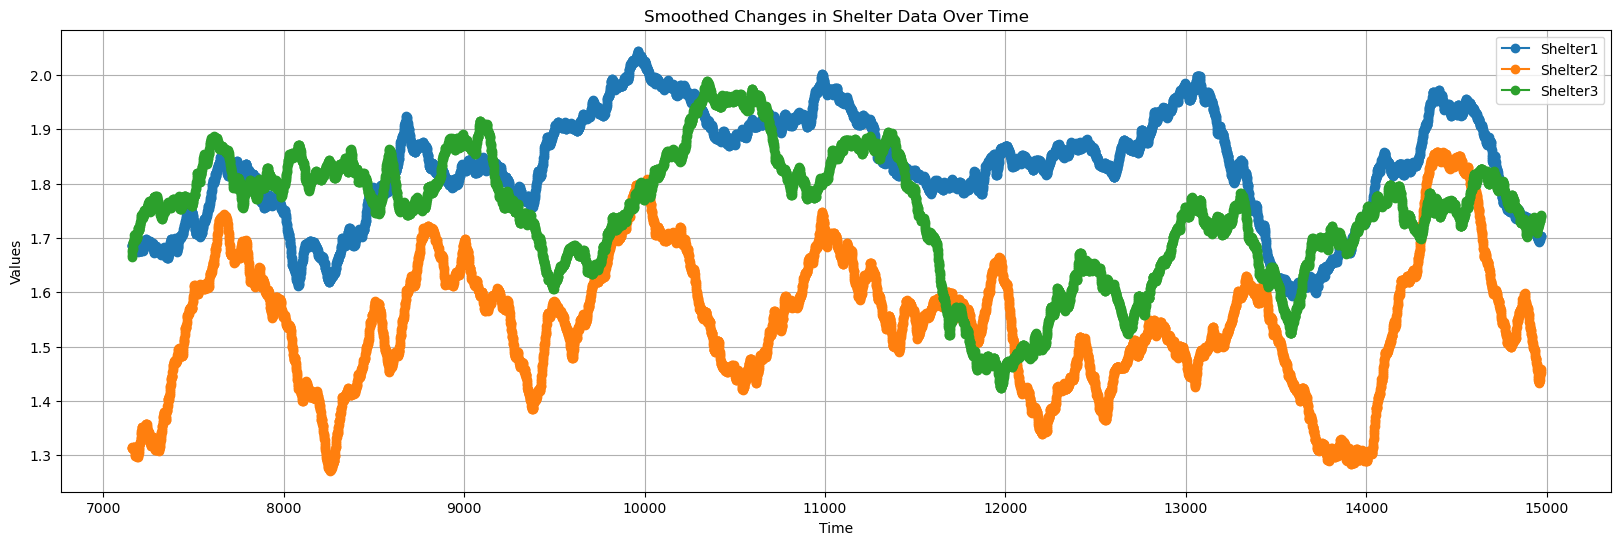

In [92]:
df = shelter_facing[6559:]

# Apply a simple moving average with a window size of 3 (adjust as needed)
smoothed_df = df.rolling(window=600).mean()

# Create a line plot for the smoothed data
plt.figure(figsize=(20, 6))
plt.plot(smoothed_df.index, smoothed_df["Shelter1"], label="Shelter1", marker='o')
plt.plot(smoothed_df.index, smoothed_df["Shelter2"], label="Shelter2", marker='o')
plt.plot(smoothed_df.index, smoothed_df["Shelter3"], label="Shelter3", marker='o')

# Customize the plot
plt.title("Smoothed Changes in Shelter Data Over Time")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
# plt.xlim((0,100))

# Show the plot
plt.show()
